# Calculation of the corrected flux excess factor for Gaia EDR3

This notebook contains example code for the calculation of the Gaia EDR3 corrected flux excess factor according to equation (6) in Riello et al. (2020).

The input data was retrieved from the Gaia EDR3 archive with the following query:
```
select source_id, bp_rp, phot_bp_rp_excess_factor
from user_edr3int4.gaia_source
where random_index between 1000000 and 1999999
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table

## Define a function that calculates the corrected flux excess factor

In [2]:
def correct_flux_excess_factor(bp_rp, phot_bp_rp_excess_factor):
    """
    Calculate the corrected flux excess factor for the input Gaia EDR3 data.
    
    Parameters
    ----------
    
    bp_rp: float, array_like
        The (BP-RP) colour listed in the Gaia EDR3 archive.
    phot_bp_rp_flux_excess_factor: float, array_like
        The flux excess factor listed in the Gaia EDR3 archive.
        
    Returns
    -------
    
    The corrected value for the flux excess factor, which is zero for "normal" stars.
    
    Example
    -------
    
    phot_bp_rp_excess_factor_corr = correct_flux_excess_factor(bp_rp, phot_bp_rp_flux_excess_factor)
    """
    
    if np.isscalar(bp_rp) or np.isscalar(phot_bp_rp_excess_factor):
        bp_rp = np.float64(bp_rp)
        phot_bp_rp_excess_factor = np.float64(phot_bp_rp_excess_factor)
    
    if bp_rp.shape != phot_bp_rp_excess_factor.shape:
        raise ValueError('Function parameters must be of the same shape!')
        
    do_not_correct = np.isnan(bp_rp)
    bluerange = np.logical_not(do_not_correct) & (bp_rp < 0.5)
    greenrange = np.logical_not(do_not_correct) & (bp_rp >= 0.5) & (bp_rp < 4.0)
    redrange = np.logical_not(do_not_correct) & (bp_rp > 4.0)
    
    correction = np.zeros_like(bp_rp)
    correction[bluerange] = 1.154360 + 0.033772*bp_rp[bluerange] + 0.032277*np.power(bp_rp[bluerange],2)
    correction[greenrange] = 1.162004 + 0.011464*bp_rp[greenrange] + 0.049255*np.power(bp_rp[greenrange],2) \
        - 0.005879*np.power(bp_rp[greenrange],3)
    correction[redrange] = 1.057572 + 0.140537*bp_rp[redrange]
    
    return phot_bp_rp_excess_factor - correction

## Test on the example data downloaded from the archive

The plot is a visual verification that the results are correct.

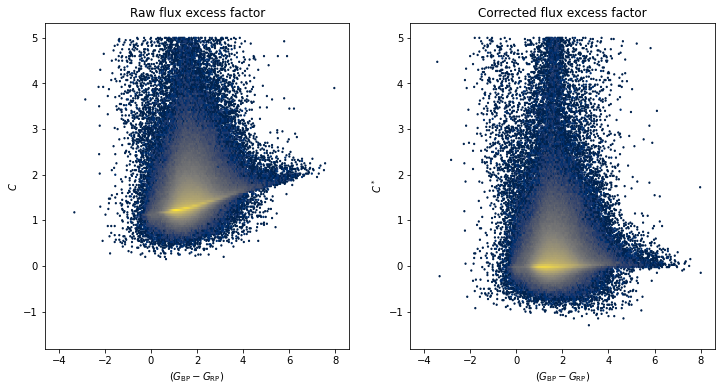

In [3]:
edr3data = Table.read('FluxExcessData.fits', format='fits')

phot_bp_rp_excess_factor_corr = correct_flux_excess_factor(edr3data['bp_rp'], edr3data['phot_bp_rp_excess_factor'])

fig, (axa, axb) = plt.subplots(1, 2, figsize=(12,6))

axa.hexbin(edr3data['bp_rp'], edr3data['phot_bp_rp_excess_factor'], bins='log', extent=[-4,8,-1.5,5], 
           cmap='cividis', mincnt=1, gridsize=(240,130))
axa.set_xlabel('$(G_\mathrm{BP}-G_\mathrm{RP}$)')
axa.set_ylabel('$C$')
axa.set_title('Raw flux excess factor')

axb.hexbin(edr3data['bp_rp'], phot_bp_rp_excess_factor_corr, bins='log', extent=[-4,8,-1.5,5],
           cmap='cividis', mincnt=1, gridsize=(240,130))
axb.set_xlabel('$(G_\mathrm{BP}-G_\mathrm{RP}$)')
axb.set_ylabel('$C^*$')
axb.set_title('Corrected flux excess factor')

plt.show()

## Verify that the code works on scalar inputs

Also verify that the code throws the expected exception when input shapes do not match.

In [4]:
comparison_values = phot_bp_rp_excess_factor_corr[0:10]

for i in range(0,10):
    corr = correct_flux_excess_factor(np.float(edr3data['bp_rp'][i]), 
                                      np.float(edr3data['phot_bp_rp_excess_factor'][i]))
    print(f'{corr:.6f} {comparison_values[i]:.6f}')

print()
try:
    corr = correct_flux_excess_factor(np.float(edr3data['bp_rp'][1]), edr3data['phot_bp_rp_excess_factor'][1:3])
    print('Previous line should have failed!')
except ValueError:
    print('Expect to land here')
    
try:
    corr = correct_flux_excess_factor(edr3data['bp_rp'][1:3], np.float(edr3data['phot_bp_rp_excess_factor'][1]))
    print('Previous line should have failed!')
except ValueError:
    print('Expect to land here')

nan nan
0.363374 0.363374
nan nan
nan nan
-0.090141 -0.090141
0.023043 0.023043
nan nan
-0.153314 -0.153314
-0.012346 -0.012346
0.204970 0.204970

Expect to land here
Expect to land here
